# Experiments and analysis for 1st paper

For each output variable [TPHYSTND_NORAD, PHQ, QRL, QRS] the $R^2$ is computed for each level $z$ and then averaged:

$$ R^2_z = 1 - (SSE_z / TVAR_z) $$

where SSE, the sum of squared errors is computed from the predicted values $y$ and the corresponding true values $\hat{y}$:

$$ SSE_z = \frac{1}{nt \times nx \times ny}\sum_{nt}\sum_{nx}\sum_{ny} (y_{t, x, y} - \hat{y}_{t, x, y})^2$$

and the TVAR, the true variance is:

$$ TVAR_Z = \frac{1}{nt \times nx \times ny}\sum_{nt}\sum_{nx}\sum_{ny} (\hat{y}_{t, x, y} - \bar{\hat{y}})^2 $$

with $\bar{\hat{y}}$ being the true mean over $t, x, y$.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cbrain.imports import *
from cbrain.model_diagnostics import *
from cbrain.utils import *
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from IPython.display import SVG, HTML
%matplotlib inline
limit_mem()

/export/home/srasp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
MODEL_DIR = '/export/home/srasp/repositories/CBRAIN-Keras-Diagnostics/saved_models/'
DATA_DIR = '/scratch/srasp/preprocessed_data/'

In [23]:
def get_d(m, trn='sample1', val='sample1'):
    d = ModelDiagnostics(
        MODEL_DIR+f'{m}.h5',
        fpath=f'{DATA_DIR}paper_nonorm_valid_{val}_features.nc',
        tpath=f'{DATA_DIR}paper_nonorm_valid_{val}_targets.nc',
        npath=f'{DATA_DIR}paper_nonorm_train_{trn}_norm.nc',
        norms=('feature_means', 'feature_stds', None, 'target_conv')
    )
    return d

## Network architecture sensitivity test

- Training: 60 days. Days 5-9 from each month of year 1.
- Validation: 60 days. Days 5-9 from each month of year 2.

The goal of this sensitivity test is to assess the number of parameters and the arrangement (shallow vs. wide).

- Number of input variables: 123
- Number of output variables: 120

All networks are trained with LeakyReLU activation functions $z(a) = \max(0.3x, x)$.

The loss function is the mean squared error.

These networks were trained with a batch size of 1024 (see sensitivity below). The starting learning rate was 1e-3. Every 5 epochs the learning rate was divided by 5. We trained for 20 epochs.

For input normalization, we are subtracting each variable by its mean and then divide it by its standard deviation to get mean zero, standard deviation one. 

For the outputs we are multiplying the heating tendencies (TPHYSTND_NORAD, QRL, QRS) by $C_p = 1 \times 10^3$ and the moistening tendency PHQ by $L_v = 2.5 \times 10^6$, so that they are all in energy units W/m^2. 


In [5]:
def npar(l):
    l = [l] if not type(l) == list else l
    l = [123] + l + [120]
    return sum([l[i] * l[i+1] + l[i+1] for i in range(len(l)-1)])

In [6]:
l_shallow = [128, 512, 2048, 8192]
l_medium = [[l]*2 for l in [90, 256, 600, 1300]]
l_deep = [[l]*8 for l in [50, 115, 256, 512]]

**Architectures**

| Approx. # Param | 30k | 125k | 500k | 2M |
| --- | --- | --- | --- | --- |
| Shallow | 128 | 512 | 2048 | 8192 |
| Medium | 90 x 2 | 256 x 2 | 600 x 2 | 1300 x 2 |
| Deep | 50 x 8 | 115 x 8 | 256 x 8 | 512 x 8 |

*Note that powers of 2 are usually chosen for GPU speed. For the sensitivity test we disregarded this sometimes.*

In [7]:
mlist_shallow = ['P001_128_sample1', 'P002_512_sample1', 'P003_2048_sample1', 'P004_8192_sample1']
mlist_medium = ['P005_90x2_sample1', 'P006_256x2_sample1', 'P007_600x2_sample1', 'P008_1300x2_sample1']
mlist_deep = ['P009_50x8_sample1', 'P010_115x8_sample1', 'P011_256x8_sample1', 'P012_512x8_sample1']

In [8]:
npars_shallow = [npar(l) for l in l_shallow]
npars_medium = [npar(l) for l in l_medium]
npars_deep = [npar(l) for l in l_deep]

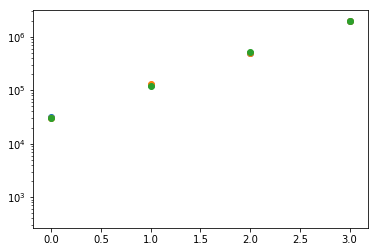

In [218]:
plt.scatter(range(4), npars_shallow, marker='o')
plt.scatter(range(4), npars_medium, marker='o')
plt.scatter(range(4), npars_deep, marker='o')
plt.gca().set_yscale('log')

In [9]:
dlist = list()
for m in mlist:
    d = get_d(m)
    if os.path.exists('./tmp/' + d.save_str): d.load_stats()
    else: d.compute_stats(); d.save_stats()
    dlist.append(d)

  8%|▊         | 224/2868 [00:24<04:51,  9.06it/s]

KeyboardInterrupt: 

  8%|▊         | 224/2868 [00:40<07:52,  5.60it/s]

In [104]:
r2s = [d.mean_stats(10)['r2_v2']['all'] for d in dlist]

/data11/home/srasp/repositories/CBRAIN-Keras-Diagnostics/notebooks/presentation/cbrain/model_diagnostics.py:275: RuntimeWarning: divide by zero encountered in true_divide
  lev_r2 = 1. - (np.mean(mse, axis=(0, 1)) / np.mean(true_var, axis=(0, 1)))


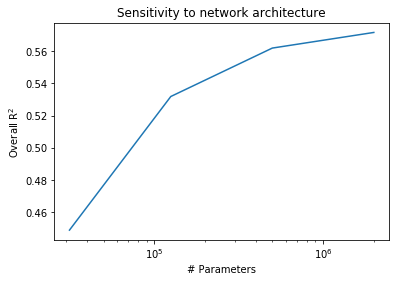

In [106]:
plt.plot(npars, r2s); plt.xlabel('# Parameters'); plt.ylabel(r'Overall R$^2$')
plt.gca().set_xscale('log'); plt.title('Sensitivity to network architecture');

### Does it matter whether we validate with 60 days or a full year?

In [10]:
d_fullyear = get_d(mlist[1], val='fullyear')

In [108]:
#d_fullyear.compute_stats(); d_fullyear.save_stats()

100%|██████████| 17519/17519 [15:33<00:00, 18.76it/s]
/data11/home/srasp/repositories/CBRAIN-Keras-Diagnostics/notebooks/presentation/cbrain/model_diagnostics.py:241: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])


In [11]:
d_fullyear.load_stats()

In [110]:
d_fullyear.mean_stats(10)

/data11/home/srasp/repositories/CBRAIN-Keras-Diagnostics/notebooks/presentation/cbrain/model_diagnostics.py:275: RuntimeWarning: divide by zero encountered in true_divide
  lev_r2 = 1. - (np.mean(mse, axis=(0, 1)) / np.mean(true_var, axis=(0, 1)))


,bias,mse,pred_mean,true_mean,pred_sqmean,true_sqmean,pred_var,true_var,r2,r2_v2
TPHYSTND_NORAD,-3.03274e-07,1.35405e-09,1.10627e-05,1.1366e-05,1.80147e-09,3.22793e-09,1.52674e-09,2.937e-09,0.244694,0.547209
PHQ,2.24975e-10,1.74521e-15,1.3343e-09,1.10933e-09,7.24496e-16,2.48544e-15,6.68094e-16,2.43478e-15,-16.9303,0.515226
QRL,4.60526e-08,1.65383e-10,-1.73767e-05,-1.74227e-05,6.63799e-10,8.43212e-10,2.71015e-10,4.46311e-10,0.532651,0.649254
QRS,4.83492e-07,7.0164e-11,6.65222e-06,6.16872e-06,1.23627e-10,1.79297e-10,5.27433e-11,1.18599e-10,-inf,0.424489
all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.534044


In [111]:
dlist[1].mean_stats(10)

/data11/home/srasp/repositories/CBRAIN-Keras-Diagnostics/notebooks/presentation/cbrain/model_diagnostics.py:275: RuntimeWarning: divide by zero encountered in true_divide
  lev_r2 = 1. - (np.mean(mse, axis=(0, 1)) / np.mean(true_var, axis=(0, 1)))


,bias,mse,pred_mean,true_mean,pred_sqmean,true_sqmean,pred_var,true_var,r2,r2_v2
TPHYSTND_NORAD,-3.11576e-07,1.34097e-09,1.09873e-05,1.12988e-05,1.78108e-09,3.19913e-09,1.48801e-09,2.88997e-09,0.0900301,0.544513
PHQ,2.24497e-10,1.73858e-15,1.32396e-09,1.09946e-09,7.19093e-16,2.47601e-15,6.58004e-16,2.42112e-15,-25.5372,0.512341
QRL,3.90402e-08,1.62918e-10,-1.74028e-05,-1.74418e-05,6.59047e-10,8.35577e-10,2.5984e-10,4.32452e-10,0.480565,0.644567
QRS,4.328e-07,6.8975e-11,6.59336e-06,6.16056e-06,1.22272e-10,1.77773e-10,5.19385e-11,1.16738e-10,-inf,0.425857
all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.531820


There is harly any difference between the statistics computed for 60 days and for a full year. To speed up analysis we will use the 60 day version.

### Batch size sensitivity

## Training amount sensitivity tests

Using selected network from above.

- Training with continuous periods:
    - 1 week
    - 1 month
    - 3 month
    - 6 month
    - 9 month
    - 12 month
- Validation
    - Test: 60 days vs full 2nd year

## Figures

### Setup

In [25]:
# Load model for figures
d = get_d('P002_512_sample1', val='sample1')

In [26]:
# Load one xarray file to get coordinates
ds = xr.open_dataset('/scratch/srasp/Aquaplanet_enhance05/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-01-00000.nc',
                     decode_times=False)

In [27]:
lat, lon = ds.lat.values, ds.lon.values

In [28]:
vars = ['TPHYSTND_NORAD', 'PHQ', 'QRL', 'QRS']

In [29]:
lims = {
    'TPHYSTND_NORAD': [-5e-4, 5e-4],
    'PHQ': [-5e-7, 5e-7],
    'QRL': [-2e-4, 2e-4],
    'QRS': [-2e-4, 2e-4],
}

In [30]:
name = {
    'TPHYSTND_NORAD': 'Convective heating rate',
    'PHQ': 'Convective moistening rate',
    'QRL': 'Longwave heating rate',
    'QRS': 'Shortwave heating rate'
}

In [31]:
unit = {
    'TPHYSTND_NORAD': '[K/s]',
    'PHQ': '[kg/kg/s]',
    'QRL': '[K/s]',
    'QRS': '[K/s]'
}

In [63]:
def plot_panels(axes, p, t, var, cmap='bwr', xlabel=True, title='var'):
    I1, I2 = [ax.pcolormesh(lon, lat, a, vmin=lims[var][0], vmax=lims[var][1], cmap=cmap) 
              for ax, a in zip(axes.flat, [p, t])]
    [ax.set_aspect('equal') for ax in axes.flat]
    if xlabel: [ax.set_xlabel('Longitude') for ax in axes.flat]
    else: [ax.set_xticks([]) for ax in axes.flat]
    axes[0].set_ylabel('Latitude'); axes[1].set_yticks([])
    if title == 'var':
        pos = [ax.get_position().get_points() for ax in axes.flat]
        x = np.mean([pos[0][0,0], pos[1][1,0]]); y = pos[0][1][1]
        plt.text(0.45, y-0.01, name[var], transform=plt.gcf().transFigure,
                 horizontalalignment='center', fontsize=14)
    else:
        axes[0].set_title('CBRAIN Predictions'); axes[1].set_title('SP-CAM Truth')
    cb = fig.colorbar(I1, ax=axes.ravel().tolist(), shrink=0.6, pad=0.01, extend='both')
    cb.set_label(unit[var])
    return I1, I2

In [64]:
def sp_wrap(axes, itime, ilev, var, **kwargs):
    p, t = d.get_pt(itime=itime, var=var)
    plot_panels(axes, p[:, :, ilev], t[:, :, ilev], var, **kwargs)

In [77]:
def animate_lat_lon(ilev, var, max_time=5, interval=200):
    p, t = d.get_pt(itime=0, var=var)
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    plt.subplots_adjust(wspace=0.03)
    I1, I2 = plot_panels(axes, p[:, :, ilev], t[:, :, ilev], var)
    fig.suptitle('Time = 0')
    def update(i):
        p, t = d.get_pt(itime=i, var=var)
        fig.suptitle(f'Time = {i}')
        I1.set_array(p[:, :, ilev].ravel()); I2.set_array(t[:, :, ilev].ravel())
        return I1, I2, 
    plt.close(fig)
    return FuncAnimation(fig, update, frames=np.arange(1, max_time), interval=interval, blit=True)

### Snapshots/animations

#### Lat-lon slices

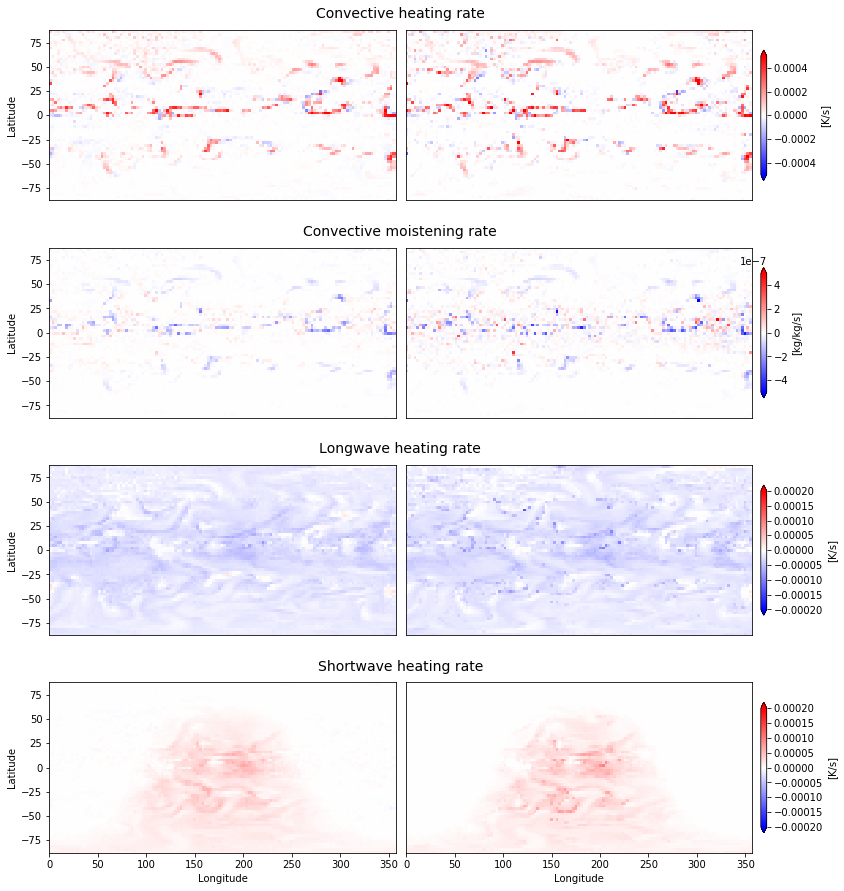

In [66]:
fig, axes = plt.subplots(4, 2, figsize=(15, 16))
plt.subplots_adjust(wspace=0.03, hspace=0.)
for i, v in enumerate(vars): sp_wrap(axes[i], 0, 20, v, xlabel = True if i == 3 else False)

In [78]:
anim = animate_lat_lon(20, 'TPHYSTND_NORAD')

In [79]:
HTML(anim.to_html5_video())

#### Lev-Lat slices

### Statistics

lat-lev, averaged over lon: MSE, TVAR, PVAR, R2, bias

lev, averaged over lat, lon: R2